In [1]:
# PRE-PROCESSING STEPS
#1. Import WV3 Imagery into ArcMap

#3. Use calculate statistics tool on raster.

#4. Open properties, check histograms for max and min values of all bands. Make sure none are 'naturally' 0.
     #4b. If NoData areas are not set, this will be reflected in a histogram spike at 0. Move to step 5. 
     #4b. If outliers exist (e.g. max/min anomlaies), use 'Generate Exclude Area' Tool. 
     #4c. Set exclusion to histogram at 0.01 and 99.9%

#5. Use 'Clip'tool to clip raster to itself, set "No Data" value as 0.0 (IMPORTANT!)
    #5b. check this by going to the layer properties, color RBG (0,0,0) and color 'NoData'. It should be classified as NoData    
    # repeat step 4

#6 open BCET code in jupyter notebooks using anaconda/python environment 'geo_env'. (where 'GDAL' and 'Rasterio' are loaded)

#7 Set bit depth dynamic range, WV3 MUL and PAN bit depth is 11-bit, SWR is 14-bit. If comparing set all as 14-bit (?)


# NOTES
# If convereting to 8 bit values (i.e. 0-255), change output dtype to uint8 in cell #4. 
# This updated BCET code will mask out values of 0.0 in the raster calulation. 
# This will allow for the proper minimums (l) to be extracted. 
# if l < b < h, then BCET fails for that band (Lui & Mason 2016, 2.6.1). 
      #Try to clip the tails of the histogram per step 4b, or change target range/mean. 



In [2]:
import numpy as np
import rasterio as rio
import numpy.ma as ma # Numpy mask

# Max and min target values for uint16 histograms

nodata = 0.0 # What pixel value do we want to mask?

bit = 11 #dynamic range of input data (used for upper range limit 'H')

L = 0 # desired output minimum
H = (2**bit) - 1  # desired output maximum, set to max bit-depth range
E = int(H/2) # desired output mean

target_WV3_file = 'data/target_image.tif'
output_WV3_file = 'outputs/output_image_BCET.tif'

print('dynamic range ', L, 'to', H) # prints the desired dynamic range of the output image
print('target mean ', E) # prints the desired mean of the output image, 'E'

dynamic range  0 to 2047
target mean  1023


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 9240, 'height': 11465, 'count': 8, 'crs': CRS.from_epsg(32719), 'transform': Affine(1.2, 0.0, 772580.3999999999,
       0.0, -1.2, 6996529.199999999), 'tiled': False, 'interleave': 'band'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


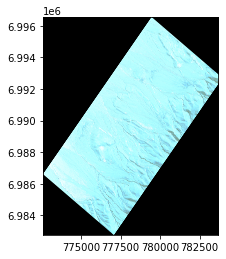

no data values (None, None, None, None, None, None, None, None)
no data None


In [3]:
# Load image into memory
wv3_src = rio.open(target_WV3_file, 'r')
wv3_profile = wv3_src.profile
print(wv3_profile) # print raster metadata

from rasterio.plot import show
show(wv3_src) # show image

print("no data values", wv3_src.nodatavals) # identify no data values in each band
print("no data", wv3_src.nodata)

In [4]:
# Create new geotiff with BCET-ed layers
# if converting to 8-bit, use next line and update final line form uint16 to uint8.

#wv3_profile.update(dtype=rio.uint8)

wv3_profile.update({'nodata':nodata}) # Update metadata with chosen nodata value

with rio.open(output_WV3_file, 'w', **wv3_profile) as wv3_bcet:
    
    # Loop through each bands
    for layer_n in range(0,wv3_profile['count']):

        # Read band
        dat = wv3_src.read(layer_n+1)
        
        ### ADD NODATA MASK ###
        nodata_array = np.full(dat.shape, nodata) # A dummy array that just contains nodata values
        mask = np.equal(dat, nodata_array) # A bitwise mask of what parts of our original data match nodata
        dat_masked = ma.array(dat, mask=mask) # Mask out nodata values so our BCET algorithm ignores them
        
        ### BCET ###
    
        s = np.mean(np.power(dat_masked,2)) # mean squared
        e = np.mean(dat_masked)
        l = np.min(dat_masked)
        h = np.max(dat_masked)

        # Find b
        b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
        b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

        b = b_nom/b_den

        # Find a
        a1 = H-L
        a2 = h-l
        a3 = h+l-(2*b)

        a = a1/(a2*a3)

        # Find c
        c = L-(a*(l-b)**2)

        # Process raster
        bcet_raster = a*((dat_masked - b)**2) + c
        
        
        ### PRINT STATISTICS OF ORIGINAL AND BCET ###
        
        # identify statistics after the bcet algorithm is applied
        bcet_min = np.min(bcet_raster)
        bcet_max = np.max(bcet_raster)
        bcet_mean = np.mean(bcet_raster)
        
        print('Band', layer_n+1) # band/layer number
        print('min ', l) # min of target file layer
        print('max ', h) # max of target file layer
        print('mean ', e) # mean of target file layer
        print('BCET min', bcet_min) # min file layer after bcet
        print('BCET max', bcet_max) # max file layer after bce
        print('BCET mean', bcet_mean) # mean file layer after bce
        
        # BCET malfunction test as in Lui & Mason (2016) Section 2.6.1. Where l<b<h BCET malfunctions. 
        if l < b < h:
          print('\033[91m'+ 'BCET Fail' + '\033[0;0m') # print in red
        else:
          print('\033[92m' + 'BCET Pass' + '\033[0;0m') # print in green
        print("l, b, h --> ", l,", ", b,", ",h)
        print('------------------------------')
    
        # Write layer to output file
        wv3_bcet.write(bcet_raster.astype(np.uint16), layer_n+1)

print("processing complete.")

Band 1
min  1
max  1374
mean  0.4994966695612096
BCET min -688667.1440735451
BCET max 2047.0
BCET mean -305320.81646687415
BCET Fail
l, b, h -->  1 ,  686.9907254604253 ,  1374
------------------------------


C:\Users\htccr\AppData\Local\Temp/ipykernel_58488/1214219553.py:29: RuntimeWarning: overflow encountered in int_scalars
  b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))


Band 2
min  1
max  1710
mean  50.32743544191661
BCET min 0.0
BCET max 2046.9999999999995
BCET mean 167.60942372895767
BCET Pass
l, b, h -->  1 ,  -395.72085243867105 ,  1710
------------------------------
Band 3
min  1
max  2047
mean  76.24424194753958
BCET min 0.0
BCET max 2047.000000000001
BCET mean 96.84839659680912
BCET Pass
l, b, h -->  1 ,  -2.1784930563507015 ,  2047
------------------------------
Band 4
min  1
max  1677
mean  29.137319814091235
BCET min 0.0
BCET max 2046.9999999999995
BCET mean 165.58896059984204
BCET Pass
l, b, h -->  1 ,  -427.91498664953474 ,  1677
------------------------------
Band 5
min  1
max  1547
mean  26.98290415438139
BCET min 0.0
BCET max 2047.0
BCET mean 212.85036666988015
BCET Pass
l, b, h -->  1 ,  -604.1949092051299 ,  1547
------------------------------
Band 6
min  1
max  1800
mean  34.2356292434638
BCET min 0.0
BCET max 2046.9999999999998
BCET mean 126.37789528426994
BCET Pass
l, b, h -->  1 ,  -276.6248406101149 ,  1800
----------------------

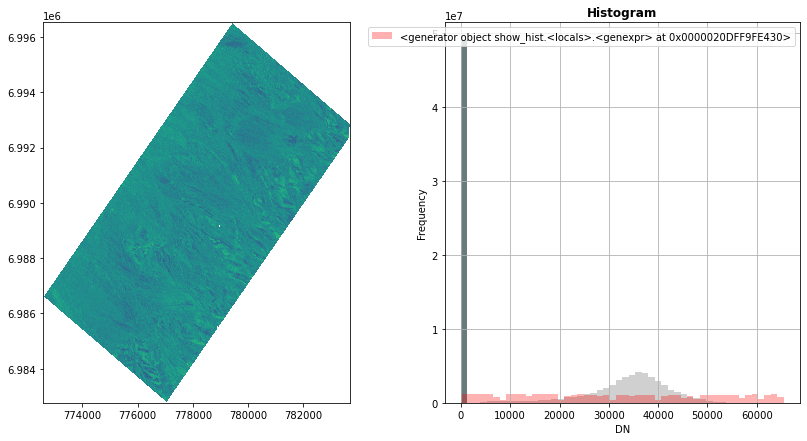

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9240, 'height': 11465, 'count': 8, 'crs': CRS.from_epsg(32719), 'transform': Affine(1.2, 0.0, 772580.3999999999,
       0.0, -1.2, 6996529.199999999), 'tiled': False, 'interleave': 'band'}


In [5]:
# Plot BCET band histograms/output file
from rasterio.plot import show_hist
import matplotlib.pyplot as plt

with rio.open(output_WV3_file) as src:
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
              lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.legend()
    plt.show()

# print raster metadata
final = rio.open(output_WV3_file, 'r')
final_profile = final.profile
print(final_profile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


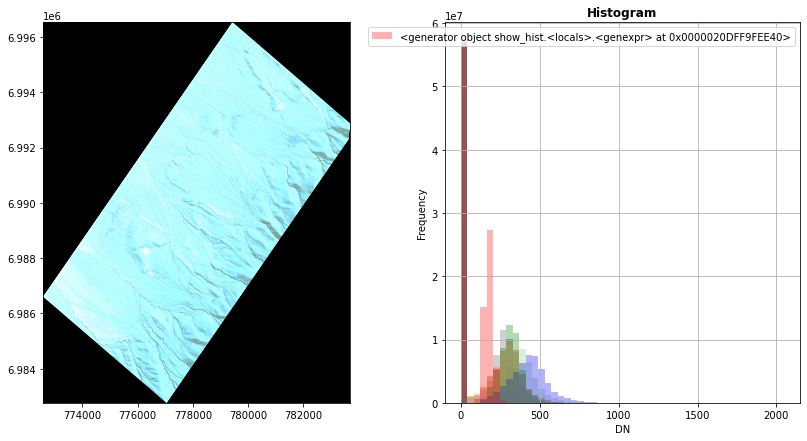

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9240, 'height': 11465, 'count': 8, 'crs': CRS.from_epsg(32719), 'transform': Affine(1.2, 0.0, 772580.3999999999,
       0.0, -1.2, 6996529.199999999), 'tiled': False, 'interleave': 'band'}


In [6]:
# plot original data/ target file
with rio.open(target_WV3_file) as src:
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
              lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.show()
    
print(wv3_profile)

In [7]:
# load, read and print final raster data to check
# Open the recently creayed BCET image file
final = rio.open(output_WV3_file, 'r')
final_profile = final.profile
print(final_profile)

# Print targeted statistics used in the BCET. Ideally the BCET image stats should match the targeted stats. 
print('------------------------------')
print('Target Min = ', L)
print('target Max ', H)
print('target mean = ', E)
print('------------------------------')

# identify actual statistics of the new BCET image file
     # should we apply the same data mask to this check? 
     # **Mean values are DIFFERENT from those identified in the BCET for loop...???**

for layer_n in range(0,wv3_profile['count']):

        # Read band
        dat = final.read(layer_n+1)
        
        e = np.mean(dat)
        l = np.min(dat)
        h = np.max(dat)
        print('Band', layer_n+1)
        print('min ', l)
        print('max ', h)
        print('mean ', e)
        print('------------------------------')



{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9240, 'height': 11465, 'count': 8, 'crs': CRS.from_epsg(32719), 'transform': Affine(1.2, 0.0, 772580.3999999999,
       0.0, -1.2, 6996529.199999999), 'tiled': False, 'interleave': 'band'}
------------------------------
Target Min =  0
target Max  2047
target mean =  1023
------------------------------
Band 1
min  0
max  65489
mean  14668.917556614051
------------------------------
Band 2
min  0
max  2046
mean  77.29182620548517
------------------------------
Band 3
min  0
max  2047
mean  44.55939133406207
------------------------------
Band 4
min  0
max  2046
mean  76.35565104033923
------------------------------
Band 5
min  0
max  2047
mean  98.21153673045954
------------------------------
Band 6
min  0
max  2046
mean  58.216849285327264
------------------------------
Band 7
min  0
max  2047
mean  32.77061837929479
------------------------------
Band 8
min  0
max  53772
mean  15694.497196795064
---------------------------